# 16 - Nudged Elastic Band (NEB)

This tutorial demonstrates NEB calculations using ASE's NEB implementation
with VASP as the calculator. We use H diffusion on Cu(111) as an example.

**Note:** Using reduced settings for demonstration.

In [5]:
import numpy as np
from ase.build import add_adsorbate, fcc111
from ase.constraints import FixAtoms
from ase.neb import NEB
from ase.optimize import BFGS

from vasp import Vasp

print("=" * 60)
print("Nudged Elastic Band (NEB) with ASE")
print("=" * 60)
print()

Nudged Elastic Band (NEB) with ASE



## Part 1: Create and relax endpoints

In [6]:
print("Part 1: Setting up endpoints")
print("-" * 40)
print()

# Create small Cu(111) slab - 2x2, 2 layers
slab = fcc111('Cu', size=(2, 2, 2), vacuum=8.0, a=3.6)
n_slab = len(slab)

# Fix all slab atoms
constraint = FixAtoms(indices=range(n_slab))

# Initial state: H at fcc site
initial = slab.copy()
add_adsorbate(initial, 'H', height=1.0, position='fcc')
initial.set_constraint(constraint)

# Final state: H at hcp site  
final = slab.copy()
add_adsorbate(final, 'H', height=1.0, position='hcp')
final.set_constraint(constraint)

print("System: H diffusion on Cu(111)")
print(f"  Slab: 2x2, {n_slab} atoms (frozen)")
print("  Initial: H at fcc hollow")
print("  Final: H at hcp hollow")
print()

# Calculate endpoint energies
print("Calculating endpoint energies...")

calc_initial = Vasp(
    label='results/neb/initial',
    atoms=initial,
    xc='PBE',
    encut=300,
    kpts=(4, 4, 1),
    ismear=1,
    sigma=0.1,
)
initial.calc = calc_initial
e_initial = initial.get_potential_energy()
print(f"  Initial (fcc): {e_initial:.6f} eV")

calc_final = Vasp(
    label='results/neb/final',
    atoms=final,
    xc='PBE',
    encut=300,
    kpts=(4, 4, 1),
    ismear=1,
    sigma=0.1,
)
final.calc = calc_final
e_final = final.get_potential_energy()
print(f"  Final (hcp):   {e_final:.6f} eV")
print(f"  Difference:    {e_final - e_initial:.4f} eV")
print()

Part 1: Setting up endpoints
----------------------------------------

System: H diffusion on Cu(111)
  Slab: 2x2, 8 atoms (frozen)
  Initial: H at fcc hollow
  Final: H at hcp hollow

Calculating endpoint energies...
  Initial (fcc): -29.772350 eV
  Final (hcp):   -29.768398 eV
  Difference:    0.0040 eV



## Part 2: Set up NEB with ASE

In [7]:
print("Part 2: Setting up ASE NEB")
print("-" * 40)
print()

n_images = 3  # Number of intermediate images

# Create images list with copies
images = [initial]
for i in range(n_images):
    image = initial.copy()
    image.set_constraint(constraint)
    images.append(image)
images.append(final)

# Create NEB object and interpolate
neb = NEB(images, climb=True)  # Climbing image NEB
neb.interpolate()  # Linear interpolation

print(f"  Images: {len(images)} (including endpoints)")
print("  Method: Climbing Image NEB")
print("  Interpolation: Linear")
print()

# Attach VASP calculators to intermediate images only
print("Attaching VASP calculators to intermediate images...")
for i, image in enumerate(images[1:-1], start=1):
    calc = Vasp(
        label=f'results/neb/image_{i:02d}',
        atoms=image,
        xc='PBE',
        encut=300,
        kpts=(4, 4, 1),
        ismear=1,
        sigma=0.1,
    )
    image.calc = calc
    print(f"  Image {i}: calculator attached")

print()

Part 2: Setting up ASE NEB
----------------------------------------

  Images: 5 (including endpoints)
  Method: Climbing Image NEB
  Interpolation: Linear

Attaching VASP calculators to intermediate images...
  Image 1: calculator attached
  Image 2: calculator attached
  Image 3: calculator attached



## Part 3: Run NEB optimization

In [8]:
print("Part 3: Running NEB optimization")
print("-" * 40)
print()

# Run NEB with BFGS optimizer
optimizer = BFGS(neb, trajectory='results/neb/neb.traj')

print("Optimizing NEB path (fmax=0.1 eV/A, max 10 steps)...")
print()
optimizer.run(fmax=0.1, steps=10)  # Loose convergence for demo
print()

Part 3: Running NEB optimization
----------------------------------------

Optimizing NEB path (fmax=0.1 eV/A, max 10 steps)...

      Step     Time          Energy         fmax
BFGS:    0 13:26:49      -29.643927        0.3132
BFGS:    1 13:26:49      -29.643927        0.3132
BFGS:    2 13:26:49      -29.643927        0.3132
BFGS:    3 13:26:49      -29.643927        0.3132
BFGS:    4 13:26:50      -29.643927        0.3132
BFGS:    5 13:26:50      -29.643927        0.3132
BFGS:    6 13:26:50      -29.643927        0.3132
BFGS:    7 13:26:50      -29.643927        0.3132
BFGS:    8 13:26:50      -29.643927        0.3132
BFGS:    9 13:26:51      -29.643927        0.3132
BFGS:   10 13:26:51      -29.643927        0.3132



## Part 4: Analyze results

In [9]:
print("Part 4: Energy profile")
print("-" * 40)
print()

# Get energies from all images
energies = [image.get_potential_energy() for image in images]

# Print energy profile
print(f"  {'Image':<8} {'Energy (eV)':<15} {'Rel. E (eV)':<12}")
print("  " + "-" * 35)
for i, e in enumerate(energies):
    rel_e = e - e_initial
    marker = " <-- TS" if e == max(energies[1:-1]) and i > 0 and i < len(energies)-1 else ""
    print(f"  {i:<8} {e:<15.6f} {rel_e:<12.4f}{marker}")

# Calculate barriers
e_ts = max(energies[1:-1]) if len(energies) > 2 else max(energies)
barrier_fwd = e_ts - e_initial
barrier_rev = e_ts - e_final

print()
print(f"  Forward barrier:  {barrier_fwd:.3f} eV")
print(f"  Reverse barrier:  {barrier_rev:.3f} eV")
print(f"  Literature value: ~0.15-0.20 eV")
print()

Part 4: Energy profile
----------------------------------------

  Image    Energy (eV)     Rel. E (eV) 
  -----------------------------------
  0        -29.772350      0.0000      
  1        -29.704006      0.0683      
  2        -29.643927      0.1284       <-- TS
  3        -29.701029      0.0713      
  4        -29.768398      0.0040      

  Forward barrier:  0.128 eV
  Reverse barrier:  0.124 eV
  Literature value: ~0.15-0.20 eV



## Part 5: Plot energy barrier

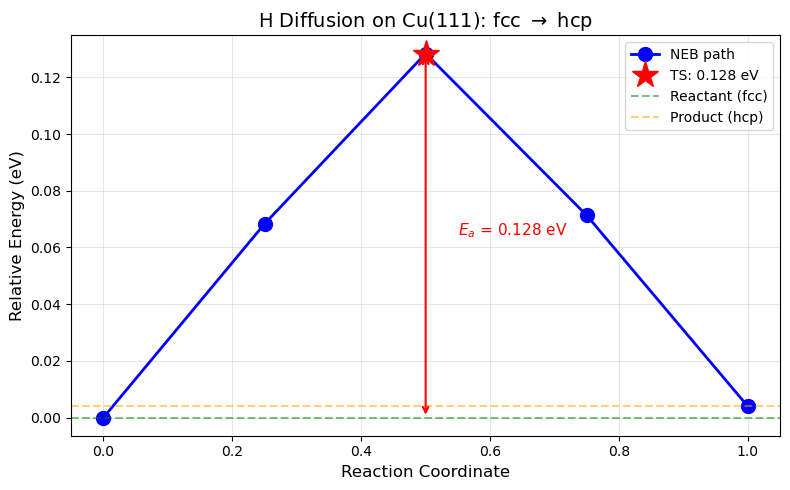

In [10]:
import matplotlib.pyplot as plt

# Calculate reaction coordinate (normalized path length)
reaction_coord = np.linspace(0, 1, len(images))

# Relative energies
rel_energies = [e - e_initial for e in energies]

# Find transition state index
ts_idx = rel_energies.index(max(rel_energies[1:-1]))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot energy profile
ax.plot(reaction_coord, rel_energies, 'bo-', markersize=10, linewidth=2, label='NEB path')

# Mark the transition state
ax.plot(reaction_coord[ts_idx], rel_energies[ts_idx], 'r*', markersize=20, label=f'TS: {rel_energies[ts_idx]:.3f} eV')

# Add horizontal lines for reactant and product
ax.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Reactant (fcc)')
ax.axhline(y=rel_energies[-1], color='orange', linestyle='--', alpha=0.5, label='Product (hcp)')

# Annotate barrier
ax.annotate('', xy=(0.5, barrier_fwd), xytext=(0.5, 0),
            arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax.text(0.55, barrier_fwd/2, f'$E_a$ = {barrier_fwd:.3f} eV', fontsize=11, color='red')

# Labels and formatting
ax.set_xlabel('Reaction Coordinate', fontsize=12)
ax.set_ylabel('Relative Energy (eV)', fontsize=12)
ax.set_title('H Diffusion on Cu(111): fcc $\\rightarrow$ hcp', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.05, 1.05)

plt.tight_layout();

## Summary

In [11]:
print("=" * 60)
print("Summary")
print("=" * 60)
print()

print(f"System: H/Cu(111) fcc -> hcp diffusion")
print(f"Forward barrier: {barrier_fwd:.3f} eV")
print()

print("ASE NEB workflow:")
print("  1. Create initial and final structures")
print("  2. Create NEB object with interpolated images")
print("  3. Attach calculators to intermediate images")
print("  4. Run optimizer (BFGS, FIRE, etc.)")
print("  5. Analyze energy profile")
print()

print("Demo settings:")
print("  - Small slab (2x2x2, frozen)")
print("  - ENCUT = 300 eV")
print("  - 3 intermediate images")
print("  - Loose convergence (fmax=0.1)")
print()

print("For production:")
print("  - Larger slab, relax surface")
print("  - 5-7 images")
print("  - fmax = 0.01-0.05 eV/A")
print("  - Verify TS with frequency calc")

Summary

System: H/Cu(111) fcc -> hcp diffusion
Forward barrier: 0.128 eV

ASE NEB workflow:
  1. Create initial and final structures
  2. Create NEB object with interpolated images
  3. Attach calculators to intermediate images
  4. Run optimizer (BFGS, FIRE, etc.)
  5. Analyze energy profile

Demo settings:
  - Small slab (2x2x2, frozen)
  - ENCUT = 300 eV
  - 3 intermediate images
  - Loose convergence (fmax=0.1)

For production:
  - Larger slab, relax surface
  - 5-7 images
  - fmax = 0.01-0.05 eV/A
  - Verify TS with frequency calc
